# Discrete time models
I wanted to try modeling the kelp time series data in discrete time. part of my motivation is that these models run much faster and so it is a bit easier to experiment, a discrete time fomultaion might also fit the data better if seasonality or other types of discrete life cycle events are important for these popualtions

These models have a very similar format to the continous time models in the other the Jupyter notebook

In [ ]:
# this requires the very lateste update from UniversalDiffEq 
# run ``] add https://github.com/Jack-H-Buckner/UniversalDiffEq.jl.git` in the julia consol
using UniversalDiffEq

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [2]:
using DataFrames, CSV
dat = CSV.read("../data/processed_time_series.csv", DataFrame)[:,2:end]
rename!(dat, ["time","series","juv","adult"])
training = dat[dat.time .< 55,:]
testing = dat[dat.time .>= 55,:]

X = CSV.read("../data/processed_rugosity.csv", DataFrame)[:,[2,3,6,7]]
rename!(X, ["time","series", "pycnopodia",  "rugosity"])
dat[1:4,:]

Row,time,series,juv,adult
,Int64,Int64,Float64,Float64
1,1,1,-1.0498,-0.197155
2,1,2,-0.0421156,-0.394327
3,1,3,0.377395,0.211176
4,1,4,-1.28535,-0.113676


In [154]:
X

Row,time,series,pycnopodia,rugosity
,Int64,Int64,Float64,Float64
1,1,1,-0.532124,-0.87251
2,2,1,-0.532124,-0.32012
3,3,1,-0.532124,-0.582861
4,4,1,-0.532124,1.78589
5,5,1,-0.532124,0.545739
6,6,1,-0.532124,-0.556138
7,1,2,-0.532124,-0.87251
8,2,2,-0.532124,-0.32012
9,3,2,-0.532124,-0.582861


In [ ]:
Vars = CSV.read("../data/kelp_obs_errors.csv", DataFrame)[:,2:end]
Σ_kelp = [Vars.sigma2[1] 0 ; 0 Vars.sigma2[2]]
Σ_kelp

# Uniform model accross sites

In [196]:
using  Random

# No covariates

NN, NNparameters = UniversalDiffEq.SimpleNeuralNetwork(2+1,2,hidden = 5)

function diff(u,i,X,p,t)
    inputs = vcat(u,X[1:1])
    u .+  NN(inputs ,p.NN)
end

init_parameters = (NN = NNparameters, )

model_1 = UniversalDiffEq.MultiCustomDifference(dat,X,diff,init_parameters;
                proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                time_column_name = "time", series_column_name = "series")
nothing

In [197]:
UniversalDiffEq.gradient_descent!(model_1,step_size = 0.05,maxiter=500, verbose = true)

2.157 1.862 1.715 1.6 1.484 1.367 1.256 1.154 1.064 0.982 0.91 0.845 0.786 0.733 0.686 0.642 0.602 0.565 0.529 0.495 0.463 0.432 0.406 0.384 0.367 0.351 0.336 0.321 0.307 0.295 0.285 0.276 0.267 0.259 0.251 0.245 0.24 0.235 0.23 0.225 0.221 0.217 0.214 0.211 0.209 0.207 0.204 0.202 0.2 0.199 0.197 0.196 0.195 0.195 0.194 0.193 0.192 0.192 0.192 0.191 0.191 0.191 0.19 0.19 0.19 0.19 0.19 0.19 0.19 0.189 0.189 0.189 0.189 0.189 0.189 0.189 0.189 0.189 0.189 0.188 0.188 0.188 0.188 0.188 0.188 0.188 0.188 0.188 0.188 0.188 0.188 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.187 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.186 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.185 0.184 0.184 0.184 0.184 0.184 0.184 0.184 0.184 0.184 0.184 0.184 0.184 0.184 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.183 0.182 0.182 

In [198]:
Pν,Px = UniversalDiffEq.kalman_filter!(model_1, Σ_kelp; verbose = true, maxiter = 250, step_size = 0.005)

3097.193 3290.734 3368.37 2808.753 2974.105 3107.933 3409.57 3322.128 3145.084 2901.818 3040.048 3037.211 3091.812 3042.707 2966.043 2907.855 2780.563 2718.705 2660.237 2613.273 2569.874 2537.22 2520.349 2584.083 2646.781 2740.642 2833.211 2700.617 2801.627 2751.862 3035.874 3065.331 2981.984 2840.394 2832.771 2703.339 2705.419 2694.646 2709.314 2796.045 2731.188 2836.375 3067.607 3242.227 3295.751 3187.452 3174.987 2944.393 2800.883 2705.082 2635.611 2575.218 2528.572 2477.14 2457.703 2414.119 2391.157 2370.325 2351.254 2334.765 2319.531 2305.641 2293.949 2285.477 2271.988 2261.098 2253.342 2246.127 2241.666 2237.213 2233.044 2229.243 2225.786 2222.623 2219.71 2217.008 2214.484 2212.114 2209.875 2207.75 2205.723 2203.782 2201.916 2200.115 2198.372 2196.677 2195.024 2193.405 2191.813 2190.238 2188.673 2187.11 2185.542 2183.961 2182.366 2180.758 2179.147 2177.546 2175.976 2174.455 2173.002 2171.631 2170.353 2169.172 2168.089 2167.094 2166.176 2165.319 2164.506 2163.724 2162.962 2162.208

([0.1574371309123366 0.0; 0.0 0.15983616577123358], [0.23290282344661398 0.023328135561399677; 0.0233281355613979 0.22593602724727288;;; 0.22137405723755757 0.03331063391355127; 0.03331063391355138 0.20957400092930686;;; 0.2089223791804359 0.03966214082687902; 0.03966214082754299 0.20484426278524157;;; … ;;; 0.218193922633982 0.04069012422453844; 0.04069012422453855 0.19231476424071522;;; 0.2231669983252851 0.033312644586431794; 0.03331264458643157 0.20158942344258154;;; 0.19941118442394154 0.03206135978203395; 0.03206135978203398 0.2193115194740952])

In [199]:
Pν,Px = UniversalDiffEq.kalman_filter!(model_1, Σ_kelp; verbose = true, maxiter = 250, step_size = 0.0025)

2427.285 2319.721 2226.959 2156.71 2088.704 1990.221 1964.582 1926.939 1906.263 1874.681 1850.804 1829.159 1804.872 1779.436 1757.138 1736.231 1714.098 1691.791 1671.941 1652.539 1633.306 1614.723 1597.436 1582.99 1570.87 1559.727 1547.638 1534.346 1520.405 1509.298 1500.619 1491.843 1485.351 1479.489 1472.28 1466.311 1462.397 1456.526 1449.928 1443.203 1437.917 1432.104 1424.832 1422.301 1418.945 1414.636 1412.558 1409.577 1405.172 1403.067 1401.695 1398.164 1394.72 1392.586 1390.451 1387.604 1384.963 1382.257 1379.854 1376.995 1374.862 1373.631 1371.657 1369.531 1366.797 1364.338 1362.664 1360.354 1357.735 1355.953 1353.914 1351.25 1349.076 1347.776 1346.081 1344.076 1342.453 1340.314 1337.132 1335.528 1334.07 1332.328 1330.481 1328.802 1327.198 1326.668 1324.915 1323.325 1322.602 1320.883 1319.285 1318.199 1316.414 1314.945 1313.916 1312.744 1311.406 1309.95 1308.505 1307.397 1306.452 1305.416 1304.427 1303.161 1302.063 1300.859 1299.935 1298.949 1298.129 1297.189 1296.313 1295.308 

([0.11812229884783838 0.0; 0.0 0.2735446392906687], [0.2048102355620694 0.007832134310078231; 0.00783213431069818 0.3609266611092102;;; 0.18355315429650348 0.029702630854534173; 0.02970263085447833 0.3345750725076175;;; 0.13305808664847413 0.006433243034233708; 0.0064332430342026806 0.3465575000057487;;; … ;;; 0.19871860179463458 0.014866405004553163; 0.014866405005550032 0.3409132770728837;;; 0.20363988717197207 0.011904679042635813; 0.011904679042922695 0.34480541871523546;;; 0.16632396700204782 0.04207001908333141; 0.0420700190832487 0.3261481636033255])

In [200]:
Pν,Px = UniversalDiffEq.kalman_filter!(model_1, Σ_kelp; verbose = true, maxiter = 250, step_size = 0.00125)

1807.129 1822.282 1761.258 1684.159 1660.562 1647.523 1633.215 1621.351 1611.403 1602.963 1595.963 1591.244 1587.765 1582.742 1576.605 1569.637 1562.062 1554.079 1545.77 1536.872 1526.544 1518.206 1511.461 1506.154 1501.541 1495.743 1489.904 1484.897 1481.126 1477.587 1474.991 1472.198 1469.232 1465.878 1461.882 1457.838 1453.545 1448.398 1442.848 1437.891 1433.593 1428.879 1422.334 1414.717 1410.489 1406.889 1403.585 1400.257 1396.837 1394.103 1391.923 1389.707 1387.398 1384.926 1382.194 1379.014 1374.916 1368.869 1365.128 1360.945 1356.328 1352.17 1348.257 1344.617 1341.129 1337.663 1334.208 1331.348 1329.545 1328.435 1326.969 1324.896 1323.705 1321.953 1319.266 1317.294 1317.236 1315.69 1312.65 1311.495 1308.922 1306.033 1304.045 1302.853 1301.859 1300.682 1299.472 1298.471 1297.666 1296.89 1296.028 1295.069 1294.127 1293.288 1292.457 1291.531 1290.601 1289.785 1288.989 1288.135 1287.307 1286.555 1285.806 1285.034 1284.279 1283.577 1282.892 1282.18 1281.456 1280.712 1279.778 1278.49

([0.1260387123255642 0.0; 0.0 0.23027928037680634], [0.21347930866959522 0.006418496054539702; 0.006418496054479306 0.3211612874963945;;; 0.19630093438685273 0.024327787650405552; 0.02432778765040533 0.29764041208769376;;; 0.1780416001398515 -0.001517314941670853; -0.0015173149418523917 0.28777337218847276;;; … ;;; 0.2055463061584202 0.015319583025048322; 0.015319583024483663 0.2985940820822617;;; 0.21172618354200082 0.011447762365130565; 0.01144776236397238 0.30244621144396433;;; 0.1741321645615215 0.04364355798263331; 0.04364355798265984 0.28024421452490156])

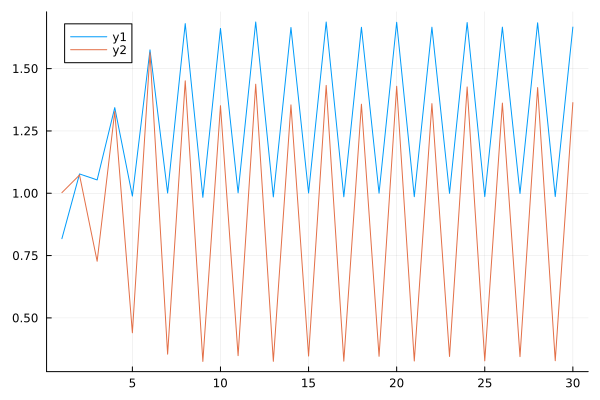

In [206]:
using Distributions, Plots

site = 6
with_noise = false
pyc = 1.0


rhs = u -> model_1.process_model.right_hand_side(u,site,[pyc],model_1.parameters.process_model,0)
u = [-0.5,-0.5]
dt_ = 0.01
kelp = []
j_kelp = []

T = 30
for i in 1:T
    u = u .+ rhs(u) 
    if with_noise
        u = u .+ rand(Distributions.MvNormal(zeros(2),Pν))
    end 

    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(1:T,exp.(kelp))
Plots.plot!(1:T,exp.(j_kelp))

### print estimated process errors

In [ ]:
Pν

# Site level indicator variables

In [59]:
using  Random

# No covariates

NN, NNparameters = UniversalDiffEq.SimpleNeuralNetwork(2+7,2,hidden = 5)

function diff(u,i,X,p,t)
    index = round(Int,i)
    one_hot = vcat(vcat(zeros(i-1),[1]),zeros(6-i))
    inputs = vcat(vcat(u,X[1:1]),one_hot)
    u .+  NN(inputs ,p.NN)
end

init_parameters = (NN = NNparameters, )

model_2 = UniversalDiffEq.MultiCustomDifference(dat,X,diff,init_parameters;
                proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                time_column_name = "time", series_column_name = "series")
nothing




In [60]:
UniversalDiffEq.gradient_descent!(model_2,step_size = 0.05,maxiter=500, verbose = true)

2.614 2.177 1.912 1.697 1.518 1.375 1.264 1.173 1.089 1.008 0.93 0.859 0.795 0.738 0.686 0.639 0.595 0.555 0.518 0.485 0.455 0.428 0.403 0.382 0.363 0.346 0.331 0.317 0.305 0.293 0.283 0.273 0.265 0.257 0.25 0.244 0.238 0.232 0.227 0.223 0.219 0.215 0.212 0.209 0.207 0.204 0.202 0.2 0.199 0.197 0.196 0.195 0.194 0.193 0.192 0.191 0.19 0.19 0.189 0.189 0.189 0.189 0.188 0.188 0.188 0.188 0.187 0.187 0.187 0.187 0.187 0.187 0.186 0.186 0.186 0.186 0.186 0.185 0.185 0.185 0.185 0.185 0.184 0.184 0.184 0.184 0.184 0.183 0.183 0.183 0.183 0.183 0.182 0.182 0.182 0.182 0.182 0.182 0.181 0.181 0.181 0.181 0.181 0.181 0.181 0.18 0.18 0.18 0.18 0.18 0.18 0.18 0.179 0.179 0.179 0.179 0.179 0.179 0.179 0.179 0.178 0.178 0.178 0.178 0.178 0.178 0.178 0.177 0.177 0.177 0.177 0.177 0.177 0.177 0.176 0.176 0.176 0.176 0.176 0.176 0.176 0.176 0.175 0.175 0.175 0.175 0.175 0.175 0.175 0.174 0.174 0.174 0.174 0.174 0.174 0.174 0.173 0.173 0.173 0.173 0.173 0.173 0.173 0.173 0.172 0.172 0.172 0.172 0.172

In [68]:
Pν,Px = UniversalDiffEq.kalman_filter!(model_2, Σ_kelp; verbose = true, maxiter = 250, step_size = 0.005)

2594.512 2490.293 1745.177 1520.875 1419.199 1389.292 1395.461 1402.936 1422.106 1414.683 1419.172 1456.348 1449.919 1506.254 1536.292 1531.15 1574.251 1628.404 1658.112 1677.115 1739.824 1756.187 1848.822 1967.192 2114.635 2185.558 2255.452 2493.081 2652.236 2621.433 2702.137 2836.577 2887.497 2717.713 2639.918 2544.508 2479.37 2405.422 2369.548 2206.211 2283.11 2297.927 2346.703 2175.807 2078.202 1972.616 1839.703 1824.064 1792.144 1741.255 1711.982 1654.5 1647.845 1634.131 1625.647 1618.925 1614.815 1610.174 1598.689 1589.201 1574.995 1665.971 1647.302 1608.007 1529.988 1573.387 1570.842 1573.763 1575.623 1571.277 1576.317 1570.125 1566.888 1555.984 1562.771 1552.924 1557.67 1547.024 1543.667 1540.597 1536.671 1538.624 1538.397 1545.66 1531.623 1530.604 1529.043 1530.691 1527.9 1528.924 1527.626 1523.308 1526.493 1526.382 1527.143 1527.814 1527.664 1527.973 1526.376 1525.245 1521.519 1518.146 1520.575 1520.368 1520.513 1517.595 1517.693 1516.154 1515.043 1513.094 1513.649 1512.326 1

([0.1083185222873799 0.0; 0.0 0.13034362152344495], [0.19715318010502234 0.002080191953496069; 0.0020801919518476097 0.23545283185551905;;; 0.19603582150089569 0.003946810578794313; 0.003946810579046556 0.23080509337249558;;; 0.19500336840871998 0.00356120873830168; 0.0035612087380947344 0.2339464927791121;;; … ;;; 0.17962670762390306 0.023600154076691027; 0.02360015407668392 0.20723627522256285;;; 0.18871205593894633 0.016032271145530075; 0.016032271145855148 0.21121242448467195;;; 0.17951790189285408 0.03670238063137532; 0.03670238063631359 0.16694331371317697])

In [69]:
Pν, Px= UniversalDiffEq.kalman_filter!(model_2, Σ_kelp; Pν = Pν, verbose = true, maxiter = 250, step_size = 0.0025)

1389.292 1364.72 1379.585 1356.363 1350.751 1358.491 1356.619 1356.464 1329.094 1294.444 1272.742 1266.904 1255.166 1256.199 1251.271 1254.323 1246.489 1240.307 1239.479 1235.022 1235.035 1236.434 1233.303 1235.562 1225.176 1227.537 1228.452 1225.69 1219.859 1229.811 1234.577 1235.985 1234.109 1233.611 1231.453 1236.436 1252.73 1286.904 1281.78 1297.61 1293.896 1307.236 1328.538 1320.364 1321.045 1331.308 1337.791 1346.309 1350.601 1352.936 1361.607 1366.631 1368.582 1373.403 1367.18 1373.034 1379.513 1379.444 1380.377 1371.001 1365.85 1344.031 1333.097 1322.785 1316.158 1313.797 1310.273 1289.57 1292.569 1301.011 1271.547 1270.772 1265.485 1261.871 1256.577 1252.693 1249.442 1244.52 1243.532 1242.961 1242.52 1238.151 1237.95 1234.365 1234.843 1234.086 1237.257 1229.037 1227.054 1226.198 1222.709 1218.641 1213.495 1206.997 1212.704 1197.707 1196.653 1193.082 1189.692 1182.346 1179.975 1178.748 1178.859 1180.962 1182.187 1182.57 1182.242 1181.401 1180.234 1179.21 1178.617 1177.933 1176.

([0.16585855469755006 0.0; 0.0 0.14859038759069895], [0.2545482432262868 0.00043704504594010984; 0.00043704504592412263 0.25738684758364394;;; 0.2539505892343995 0.0028254123199964454; 0.002825412320030196 0.25238344268752344;;; 0.2539728882136493 0.0007280813344321402; 0.0007280813344321402 0.2568287356660258;;; … ;;; 0.23442195686171086 0.02566828338657068; 0.025668283387791035 0.22462631171692612;;; 0.24622674795931576 0.01604614105373514; 0.016046141052971308 0.22978986401788268;;; 0.23636125642542527 0.03729566546345353; 0.037295665462096395 0.185665824489566])

In [70]:
Pν, Px= UniversalDiffEq.kalman_filter!(model_2, Σ_kelp; Pν = Pν, verbose = true, maxiter = 500, step_size = 0.00125)

1128.996 1139.107 1135.858 1128.409 1143.495 1155.521 1158.776 1158.901 1159.53 1158.685 1156.773 1152.643 1145.831 1137.774 1132.767 1132.519 1133.526 1137.04 1135.471 1134.282 1136.355 1137.21 1141.31 1149.262 1177.108 1177.461 1165.465 1168.307 1170.573 1172.641 1173.057 1172.025 1168.872 1170.817 1168.418 1164.458 1163.056 1162.232 1159.759 1156.907 1154.73 1152.559 1149.782 1148.985 1147.914 1144.059 1141.98 1140.644 1143.523 1137.688 1137.133 1136.915 1136.169 1135.303 1134.606 1133.828 1132.943 1131.65 1130.063 1128.683 1126.726 1125.424 1125.021 1124.76 1123.175 1119.702 1119.234 1117.004 1114.802 1113.75 1113.423 1113.402 1112.81 1111.456 1110.801 1110.867 1110.008 1108.481 1107.854 1107.651 1106.753 1105.525 1104.725 1103.841 1103.087 1102.944 1102.664 1102.292 1101.542 1100.697 1100.759 1100.649 1099.825 1099.324 1099.281 1098.788 1098.201 1098.053 1097.843 1097.389 1097.16 1096.876 1096.535 1096.379 1096.068 1095.723 1095.433 1095.14 1094.995 1094.746 1094.439 1094.278 1094

([0.1348318461585191 0.0; 0.0 0.14347599665225577], [0.2244940310979683 -0.00022484008615730744; -0.00022484008616618922 0.25099158404983635;;; 0.22271026723161538 0.0028646487850352287; 0.0028646487850387814 0.24731436661343711;;; 0.22191371992906075 0.002634454152847354; 0.002634454152633303 0.24846926104349745;;; … ;;; 0.19282732661729632 0.032038475634765806; 0.032038475634768915 0.21635098774053976;;; 0.21044756489044372 0.021691820860949562; 0.021691820858201538 0.21819097419895375;;; 0.2048349399981856 0.03782093328019087; 0.03782093328130287 0.18016357178520384])

In [71]:
Pν

2×2 Matrix{Float64}:
 0.134832  0.0
 0.0       0.143476

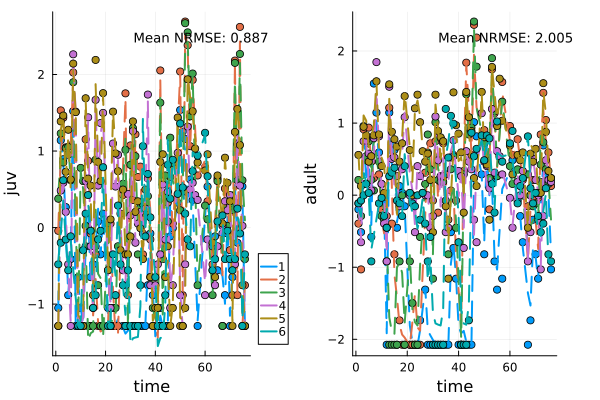

In [72]:
UniversalDiffEq.plot_state_estimates(model_2)

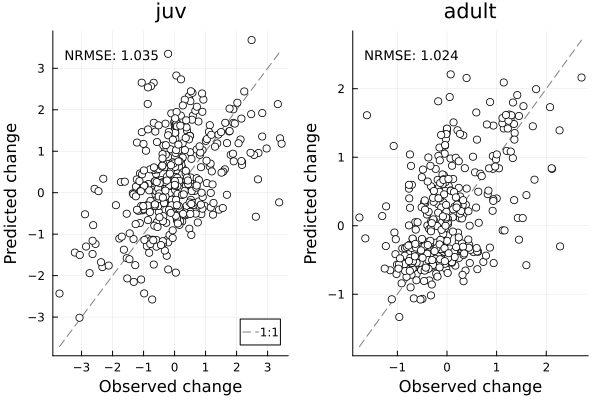

In [73]:
UniversalDiffEq.plot_predictions(model_2)

# Site level environemtanl variables (sea floor roughness) 

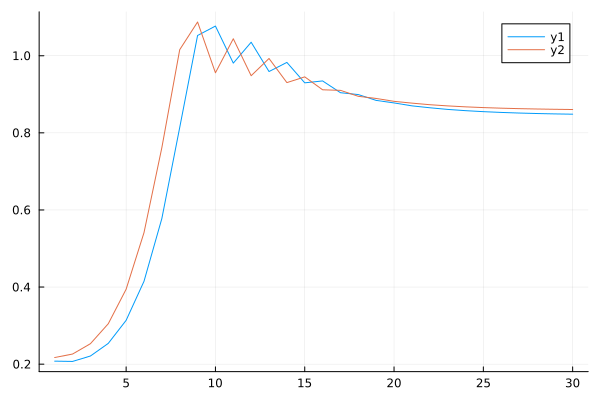

In [ ]:
using Distributions, Plots

site = 6
with_noise = false
sigma = 1.0
pyc = 0.0
rug = 0.0


rhs = u -> model_2.process_model.right_hand_side(u,site,[pyc,rug],model_2.parameters.process_model,0)
u = [-1.5,-1.5]
dt_ = 0.01
kelp = []
j_kelp = []

T = 30
for i in 1:T
    u = u .+ rhs(u) 
    if with_noise
        u = u .+ rand(Distributions.MvNormal(zeros(2),Pν))
    end 

    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(1:T,exp.(kelp))
Plots.plot!(1:T,exp.(j_kelp))

## Differnt local environemtanl factors

In [166]:
# No covariates

NN, NNparameters = UniversalDiffEq.SimpleNeuralNetwork(2+2,2,hidden = 5)

function diff(u,i,X,p,t)
    inputs = vcat(u,X)
    u .+  NN(inputs,p.NN)
end

init_parameters = (NN = NNparameters, )

model_3 = UniversalDiffEq.MultiCustomDifference(dat,X,diff,init_parameters;
                proc_weight=1.0,obs_weight=1.0,reg_weight=10^-4,
                time_column_name = "time", series_column_name = "series")
nothing

In [171]:
UniversalDiffEq.gradient_descent!(model_3,step_size = 0.05,maxiter=500, verbose = true)

0.472 0.437 0.382 0.352 0.331 0.307 0.287 0.274 0.264 0.255 0.246 0.239 0.233 0.229 0.225 0.222 0.219 0.216 0.213 0.211 0.209 0.208 0.206 0.205 0.203 0.201 0.2 0.199 0.198 0.197 0.196 0.195 0.194 0.194 0.193 0.192 0.191 0.191 0.19 0.19 0.189 0.189 0.189 0.188 0.188 0.188 0.188 0.187 0.187 0.187 0.187 0.187 0.187 0.186 0.186 0.186 0.186 0.186 0.185 0.185 0.185 0.184 0.184 0.184 0.183 0.183 0.182 0.182 0.181 0.18 0.179 0.178 0.177 0.176 0.177 0.179 0.174 0.173 0.175 0.169 0.172 0.17 0.167 0.17 0.164 0.166 0.163 0.162 0.164 0.163 0.174 0.173 0.161 0.168 0.163 0.162 0.162 0.158 0.162 0.155 0.16 0.154 0.159 0.153 0.156 0.152 0.154 0.152 0.152 0.151 0.151 0.15 0.15 0.15 0.148 0.149 0.147 0.147 0.147 0.146 0.147 0.146 0.145 0.145 0.146 0.145 0.146 0.152 0.152 0.146 0.149 0.147 0.149 0.15 0.143 0.15 0.15 0.145 0.149 0.146 0.147 0.146 0.142 0.145 0.142 0.143 0.143 0.141 0.143 0.142 0.141 0.142 0.141 0.141 0.142 0.142 0.141 0.141 0.141 0.14 0.141 0.141 0.141 0.142 0.145 0.146 0.147 0.143 0.14 0.

In [172]:
Pν,Px = UniversalDiffEq.kalman_filter!(model_3, Σ_kelp; verbose = true, maxiter = 250, step_size = 0.005)

2021.39 1967.891 2005.369 1984.197 2127.58 2123.191 2035.688 2353.195 2136.649 2121.316 2307.188 2232.837 2204.766 2235.986 2014.54 2000.362 2002.556 2050.543 2124.67 2340.199 2272.515 2295.037 2125.384 2364.524 2024.502 1997.051 2005.241 2406.14 2173.681 2184.745 2094.018 2020.927 2379.277 2264.979 2279.935 2118.415 2294.268 2233.142 2472.433 2388.466 2557.844 2803.693 2584.299 3043.953 2976.314 3068.103 3108.321 3210.119 3175.807 2848.095 2731.779 2669.365 2624.267 3604.84 7924.521 5838.581 2563.541 2714.946 4331.026 4428.27 5477.014 5277.581 5300.055 3687.515 2668.156 2670.27 3447.154 3479.923 2602.243 2717.628 3240.268 3401.292 3453.259 3466.431 5418.925 4753.568 4799.903 3428.421 4740.391 4712.659 4874.778 4782.592 3485.184 4861.672 4879.43 4828.048 4737.014 4808.122 4897.02 4990.427 5135.646 6493.613 6380.823 4995.099 4914.44 4858.723 4683.441 4757.997 4626.549 4802.273 4756.446 4748.337 4834.587 4827.416 4765.478 4919.295 6439.018 4791.322 4679.843 4710.9 4779.358 4780.24 4749.8

([0.0948678449592929 0.0; 0.0 0.10436495349399307], [0.18045353544277354 -0.00039529060889187395; -0.00039529060891918544 0.2115337024240796;;; 0.1813670246271467 0.011352973596530092; 0.01135297359600429 0.17461494096959168;;; 0.1748266694852031 -0.022917954106051575; -0.022917954105694083 0.1547293178530001;;; … ;;; 0.17906217975105798 0.002539750275779795; 0.0025397502758117696 0.21219152471931718;;; 0.1814709833074456 -0.004999353555461994; -0.004999353555717789 0.20590781136177722;;; 0.17688481744461304 -0.017946799643837608; -0.017946799644306566 0.17218958160454317])

In [173]:
Pν, Px= UniversalDiffEq.kalman_filter!(model_3, Σ_kelp; Pν = Pν, verbose = true, maxiter = 250, step_size = 0.0025)

1967.891 2342.865 2015.913 1938.952 1937.985 1962.97 2000.936 1932.31 2036.657 1928.931 1904.731 1889.107 1842.057 1832.687 1974.351 2078.502 2094.763 1986.057 1951.378 1985.222 2059.238 2139.016 2009.373 2243.453 2090.975 2046.433 2033.87 2149.366 1954.046 2120.105 2184.548 2278.6 2196.438 2291.503 2123.595 2224.646 2389.222 2539.254 2518.589 2398.902 2487.369 2294.587 2455.263 2292.228 2183.729 2097.565 2367.279 2310.179 2268.105 2102.368 2202.51 2086.687 2197.227 2305.929 2293.76 2292.331 2248.48 2144.82 2239.124 2305.851 2186.569 2168.231 2187.579 2294.355 2167.814 2250.168 2352.514 2219.721 2252.332 2355.505 2284.608 2209.107 2268.001 2272.241 2233.056 2305.975 2286.175 2252.044 2229.422 2291.938 2230.58 2220.889 2258.224 2339.846 2269.515 2330.105 2254.269 2310.588 2334.855 2355.184 2323.331 2332.424 2310.986 2334.588 2317.586 2381.98 2351.839 2355.139 2288.918 2327.938 2209.862 2221.951 2316.06 2340.419 2280.79 2363.273 2243.935 2289.021 2453.506 2269.831 2353.87 2268.796 2455.4

([0.15075515407406861 0.0; 0.0 0.08979543189956035], [0.23999156233541477 -0.000734075982604665; -0.0007340759826153231 0.197397224170553;;; 0.2400996759776313 0.0017690807879784387; 0.0017690807879766624 0.19065889317103063;;; 0.22816725656705053 -0.029335581582520476; -0.02933558158339178 0.12414980914422075;;; … ;;; 0.23563763528378637 0.003084455226350258; 0.003084455226197491 0.19697541806917956;;; 0.21597949873120062 -0.00822862577495087; -0.008228625775390075 0.19340739230919785;;; 0.22892415717933481 -0.022430375470563035; -0.02243037547081883 0.1556134663689443])

In [174]:
Pν, Px= UniversalDiffEq.kalman_filter!(model_3, Σ_kelp; Pν = Pν, verbose = true, maxiter = 500, step_size = 0.00125)

1799.152 1855.246 1869.162 1923.226 1958.614 1996.293 1974.161 1957.145 1981.042 1912.031 1923.504 1916.456 1838.437 1870.587 1848.977 1846.553 1852.551 1874.841 1882.281 1904.772 1966.884 1946.306 1923.242 1905.932 1914.405 1906.278 1933.229 1899.268 1878.758 1879.069 1839.559 1875.215 1869.769 1826.347 1879.601 1835.945 1845.919 1838.653 1833.506 1865.451 1901.564 1845.934 1868.734 1898.639 1824.571 1889.075 1875.166 1858.287 1863.49 1866.631 1877.922 1900.513 1863.885 1858.713 1867.998 1881.019 1879.444 1874.607 1912.708 1870.063 1886.494 1913.877 1915.049 1924.001 1911.0 1914.957 1910.885 1924.332 1916.414 1910.692 1911.731 1926.39 1927.3 1922.73 1922.425 1925.009 1925.895 1931.115 1928.458 1911.924 1902.962 1903.004 1903.34 1903.511 1903.044 1902.168 1901.199 1900.675 1900.922 1898.293 1896.185 1898.568 1900.315 1898.901 1913.515 1953.553 1938.175 1927.095 1918.858 1910.537 1924.977 1911.79 1932.997 1929.918 1920.864 1937.456 1913.564 1899.393 1891.838 1896.056 1910.499 1903.267 1

([0.15075515407406861 0.0; 0.0 0.08979543189956035], [0.23999156233541477 -0.000734075982604665; -0.0007340759826153231 0.197397224170553;;; 0.2400996759776313 0.0017690807879784387; 0.0017690807879766624 0.19065889317103063;;; 0.22816725656705053 -0.029335581582520476; -0.02933558158339178 0.12414980914422075;;; … ;;; 0.23563763528378637 0.003084455226350258; 0.003084455226197491 0.19697541806917956;;; 0.21597949873120062 -0.00822862577495087; -0.008228625775390075 0.19340739230919785;;; 0.22892415717933481 -0.022430375470563035; -0.02243037547081883 0.1556134663689443])

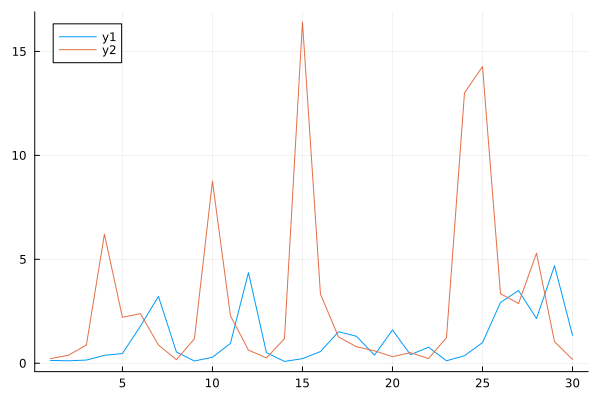

In [195]:
using Distributions, Plots

site = 1
with_noise = true
sigma = 1.0
pyc = 0.0
rug = 1.0


rhs = u -> model_3.process_model.right_hand_side(u,site,[pyc,rug],model_3.parameters.process_model,0)
u = [-1.5,-1.5]
dt_ = 0.01
kelp = []
j_kelp = []

T = 30
for i in 1:T
    u = u .+ rhs(u) 
    if with_noise
        u = u .+ rand(Distributions.MvNormal(zeros(2),Pν))
    end 

    push!(kelp,u[2])
    push!(j_kelp,u[1])
end
Plots.plot(1:T,exp.(kelp))
Plots.plot!(1:T,exp.(j_kelp))